<a href="https://colab.research.google.com/github/BachiLi/redner/blob/master/tutorials/background_and_color_space_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Redner's rendering functions can also output alpha channel. You can use this to composite rendered images with arbitrary background images.

In [1]:
!pip install --upgrade redner-gpu

     |████████████████████████████████| 33.1MB 92.1MB/s 


In [2]:
# Tensorflow by default allocates all GPU memory, leaving very little for rendering.
# We set the environment variable TF_FORCE_GPU_ALLOW_GROWTH to true to enforce on demand
# memory allocation to reduce page faults.
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
%tensorflow_version 2.x
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import pyredner_tensorflow as pyredner

TensorFlow 2.x selected.


We will download a famous test image in signal processing literature from the [SIPI image database](http://sipi.usc.edu/database/database.php?volume=misc&image=10#top).

An important thing to keep in mind is that alpha blending is only *correct* in a [linear color space](https://www.kinematicsoup.com/news/2016/6/15/gamma-and-linear-space-what-they-are-how-they-differ). Natural 8-bit images you download from the internet is usually gamma compressed. Redner's `imread` function automatically converts the image to linear space (assuming gamma=2.2), so when displaying them you want to convert them back to the gamma compressed space. 

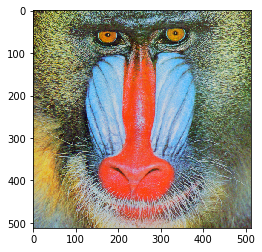

In [4]:
import urllib
filedata = urllib.request.urlretrieve('http://sipi.usc.edu/database/download.php?vol=misc&img=4.2.03', 'mandrill.tiff')
background = pyredner.imread('mandrill.tiff')
# Visualize background
from matplotlib.pyplot import imshow
%matplotlib inline
# Redner's imread automatically gamma decompress the image to linear space.
# You'll have to compress it back to sRGB space for display.
imshow(tf.pow(background, 1.0/2.2))

This time we'll use a simpler geometry -- a sphere. We can use generate_sphere to procedurally generate the triangle mesh geometry of a sphere.

Scene construction, time: 22.44733 s
Forward pass, time: 0.07953 s


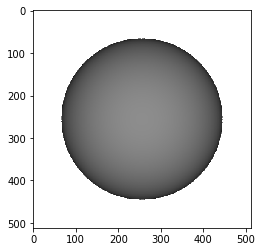

In [5]:
# The steps arguments decide how many triangles are used to represent the sphere.
vertices, indices, uvs, normals = pyredner.generate_sphere(theta_steps = 64, phi_steps = 128)
m = pyredner.Material(diffuse_reflectance = tf.constant([0.5, 0.5, 0.5]))
sphere = pyredner.Object(vertices = vertices, indices = indices, uvs = uvs, normals = normals, material = m)
cam = pyredner.automatic_camera_placement(shapes=[sphere], resolution=(background.shape[0], background.shape[1]))
scene = pyredner.Scene(camera=cam, objects=[sphere])
lights = [pyredner.PointLight(cam.position,
                              tf.constant([10.0, 10.0, 10.0]))]
img = pyredner.render_deferred(scene=scene, lights=lights, alpha=True)
imshow(tf.pow(img, 1.0/2.2))

Note that we set `alpha=True`. `img` is now a 4-channels image.

In [6]:
print(img.shape)

(512, 512, 4)


We can alpha blend the image and the background like the following.

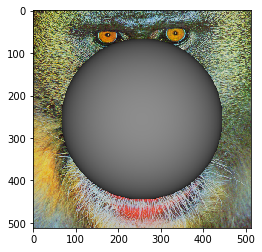

In [7]:
alpha = img[:, :, 3:4]
blend_img = img[:, :, :3] * alpha + background * (1 - alpha)
imshow(tf.pow(blend_img, 1.0/2.2))

Note that it is not advisible to include `tf.pow(img, 1.0/2.2)` in the loss computation, since the derivative of `x^(1/2.2)` is negative infinite at `x=0`. There are two workarounds for this: first, you can invert the operation on the target (e.g., `tf.pow(target, 2.2)`). Second, you can use the [sRGB conversion](https://entropymine.com/imageworsener/srgbformula/), which uses a linear function near zero.